## Look at tasks that spread over multiple days

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import pymongo
from pymongo import MongoClient
from bson.objectid import ObjectId
from datetime import datetime
import itertools
import re
import matplotlib.pylab as pylab
import numpy as np
from scipy import percentile
from scipy.stats import pearsonr, kendalltau
import math

# DB connection to localhost
client = MongoClient()
# Get DB
db = client.db_tasklog_clean
# collection to store new data that contains task labels
# Note: only top-level task labels are used
DataLabeled = db.data_labeled
Users = db.user

users = list(Users.find({}))

In [2]:
# Flatten the data to streams of events
D = []
# Get tasks length
for u in users:
    data = list(DataLabeled.find({'userid': u['userid']}))[0]['data']
    events = []
    # data consists of tab-groups
    for s in data:
        tab_group = s['tab_group']
        tabid = s['tabid']
        # tab groups consist of url groups
        for ug in tab_group:
            # a group of events sharing the same url
            url_group = ug['url_group']
            for e in url_group:
                events.append(e)
    D.append((u['userid'], events))
            

In [4]:
# Tasks to be filtered out
Filter = ['None', '000', '001', '002', '003', '004']
# Tasks annotated with postQ
postQ = [u['postQ']['questionnaire'].keys() for u in users]
postQ_tasks = [x for sublist in postQ for x in sublist]

In [31]:
# Get task properties
T_prop = {}
TO_FILTER = ['task_goals_quantity']
bloom_map = {
    'remember': 1,
    'understadn': 2,
    'apply': 3,
    'analyse': 4,
    'evaluate': 5,
    'create': 6
}
for u in users:
    Q = u['postQ']['questionnaire']
    for q in Q:
        for question in Q[q].keys():
            if question in TO_FILTER:
                continue
            answers = T_prop.get(question, {})
            a = Q[q][question]
            # process bloom's taxonomy
            if question == 'task_complexity_objective':
                a = bloom_map[a]
            answers.update({q:a})
            T_prop[question] = answers

In [8]:
# Task length in terms of total seconds
T_length = {}
for uid, data in D:
    tasks = [(d['taskid'], d['timestamp_bson']) for d in data if d['taskid'] not in Filter]
    tasks.sort(key=lambda x: x[0])
    for k, g in itertools.groupby(tasks, lambda x: x[0]):
        g = sorted(list(g), key=lambda x: x[1])        
        # Get task length
        T_length[k] = (g[-1][1] - g[0][1]).total_seconds()

## Descriptive stats
* How many tasks spreads over days (and annotated with postQ)
* How many queries would users go before first click (cf. Daan)
* How often do people directly go to a website to solve their (long term) tasks instead of using a SE? 
* How often do people need to re-issue the same queries in a different session for the same task?
* How different are queries issued in the same session of the same task? and in the different sessions of the same task? (exploration vs. struggling?)

### Number of queries users issue - Only consider tasks with postQ annotation from now on
* Number of queries per task
* Correlation between number of queries and task length
* Correlation between number of queries and task properties 
* Chi-square between long/short tasks

In [32]:
# Type of search events: tab-search-new, tab-search-backward, tab-search-verticle, 
# tab-search-pagination, tab-search-noquery
# Only consider new and verticle change as issuing query
query_events = ['tab-search-new', 'tab-search-verticle']

Qcount = dict([(t, 0) for t in postQ_tasks])
# Get query events for each task
for uid, data in D:
    q_events = list(itertools.ifilter(lambda x: x['event'] in query_events and x['taskid'] in postQ_tasks, data))
    q_events.sort(key=lambda x: x['taskid'])
    for k, g in itertools.groupby(q_events, lambda x: x['taskid']):
        Qcount[k] = len(list(g))

# Correlation: T_length vs. Qcount
# Get the common set of tasks
T = list(set(Qcount.keys()).intersection(set(T_length.keys())))
X = [Qcount[t] for t in T]
Y = [T_length[t] for t in T]
r, p = pearsonr(X, Y)
print 'Correlation number of query vs. task length r=%.2f, p-value=%.2f'%(r, p) 
print

print 'Correlation number query vs. task properties:'
i = 1
for prop in T_prop:
    answers = T_prop[prop]
    S = [answers[t] for t in T]
    tau, p = kendalltau(X, S)
    print i,
    if p < 0.05:
        print '\\textbf{', prop, '}', 
    else:
        print prop,
    print '%.2f'%tau, '%.2f'%p
    i += 1

Correlation number of query vs. task length r=0.28, p-value=0.01

Correlation number query vs. task properties:
1 task_stage -0.04 0.59
2 task_collaboration 0.12 0.10
3 \textbf{ task_difficulty_subjective } 0.17 0.02
4 task_sailence_subjective 0.05 0.50
5 task_urgency_subjective 0.13 0.07
6 task_frequency -0.04 0.58
7 task_satisfaction -0.10 0.19
8 \textbf{ task_knowledge_topic } -0.23 0.00
9 \textbf{ task_complexity_objective } 0.25 0.00
10 task_knowledge_procedure -0.11 0.13
11 \textbf{ task_length } 0.28 0.00
12 \textbf{ task_complexity_subjective } 0.20 0.01


### Number of clicks on SERPs
* Number of SERP clicks per task
* Correltaion between number of SERP clicks and task length
* Chi-square with long/short tasks
* Correlation between number of SERP clicks and task properties

In [42]:
Ccount = dict([(t, 0) for t in postQ_tasks])
for uid, data in D:
    C_events = list(itertools.ifilter(lambda x: x['event'] == 'link_click-SERP-result' 
                    and x['taskid'] in postQ_tasks, data))
    C_events.sort(key=lambda x: x['taskid'])
    for k, g in itertools.groupby(C_events, lambda x: x['taskid']):
        g = list(g)
        Ccount[k] = len(g)

# Correlation: T_length vs. Ccount
# Get the common set of tasks
T = list(set(Ccount.keys()).intersection(set(T_length.keys())))
X = [Ccount[t] for t in T]
Y = [T_length[t] for t in T]

r, p = pearsonr(X, Y)
print 'Correlation number of SERP clicks vs. task length r=%.2f, p-value=%.2f'%(r, p) 
print

print 'Correlation number SERP clicks vs. task properties:'
i = 1
for prop in T_prop:
    answers = T_prop[prop]
    S = [answers[t] for t in T]
    tau, p = kendalltau(X, S)
    print i,
    if p < 0.05:
        print '\\textbf{', prop, '}', 
    else:
        print prop,
    print '%.2f'%tau, '%.2f'%p
    i += 1

Correlation number of SERP clicks vs. task length r=0.28, p-value=0.01

Correlation number SERP clicks vs. task properties:
1 task_stage -0.12 0.10
2 task_collaboration 0.12 0.11
3 task_difficulty_subjective 0.13 0.09
4 task_sailence_subjective 0.01 0.85
5 task_urgency_subjective 0.11 0.13
6 task_frequency -0.05 0.46
7 task_satisfaction -0.14 0.06
8 \textbf{ task_knowledge_topic } -0.28 0.00
9 \textbf{ task_complexity_objective } 0.24 0.00
10 task_knowledge_procedure -0.14 0.06
11 \textbf{ task_length } 0.35 0.00
12 \textbf{ task_complexity_subjective } 0.20 0.01


## Number of queries before first click
* Number of queries before first SERP click per task
* correlation between number of queries before first SERP click and task length
* correlation between number of queries before first SERP click and task properties

In [57]:
google_reg = re.compile('.+?\.google\..+?q=.+')
yahoo_reg = re.compile('.+?\.search\.yahoo\..+?p=.+')
bing_reg = re.compile('.+?\.bing\..+?q=.+')

def check_serp(url):
    # This may involve other service of google/bing, but it's not a big problem for
    # now
    if len(google_reg.findall(url)) > 0 or len(yahoo_reg.findall(url)) > 0 or len(bing_reg.findall(url)) > 0:
        return True
    else:
        return False

With search: 0.81
No search: 0.19
Abandoned search: 0.04
Correltaion between number of queries before first click and task length: r=0.09, p=0.45

Correlation number queries before 1st clicks vs. task properties:
1 task_stage 0.05 0.56
2 task_collaboration -0.04 0.60
3 \textbf{ task_difficulty_subjective } 0.22 0.01
4 \textbf{ task_sailence_subjective } 0.19 0.02
5 task_urgency_subjective 0.10 0.22
6 \textbf{ task_frequency } 0.18 0.03
7 task_satisfaction -0.07 0.39
8 task_knowledge_topic 0.15 0.07
9 \textbf{ task_complexity_objective } 0.29 0.00
10 task_knowledge_procedure 0.09 0.31
11 task_length -0.01 0.94
12 task_complexity_subjective 0.13 0.11


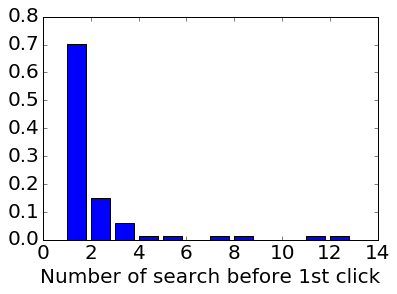

In [106]:
FC = []
for uid, data in D:
    # Group events by tasks, order in time
    data.sort(key=lambda x: x['taskid'])
    for k, g in itertools.groupby(data, lambda x: x['taskid']):
        if not k in postQ_tasks:
            continue
        g = sorted(list(g), key=lambda x: x['timestamp_bson'])
        
        no_search = True
        no_click = True
        search = 0
        # Count the number of queries before first SERP click
        for e in g:
            if e['event'] in query_events:
                no_search = False
                search += 1
            if e['event'] == 'link_click-SERP-result':
                no_click = False
                break
        FC.append([k, search, no_search, no_click])

# ratio of search, no search, abandoned search
withS = list(itertools.ifilter(lambda x: x[2] == False, FC))
noS = list(itertools.ifilter(lambda x: x[2] == True, FC))
ABD = list(itertools.ifilter(lambda x: x[2] == False and x[3] == True, FC))
tot = float(len(FC))

print 'With search: %.2f'%(len(withS)/tot)
print 'No search: %.2f'%(len(noS)/tot)
print 'Abandoned search: %.2f'%(len(ABD)/float(len(withS)))

firstClick = list(itertools.ifilter(lambda x: x[2] == False and x[3] == False, FC))
X = sorted([x[1] for x in firstClick])
Y = []
idx = []
for k, g in itertools.groupby(X):
    Y.append((len(list(g)))/float(len(firstClick)))
    idx.append(k)
pylab.bar(idx, Y)
pylab.xlabel('Number of search before 1st click')

# Correlations
X = [t[1] for t in firstClick]
Y = [T_length[t[0]] for t in firstClick]
r, p = pearsonr(X, Y)
print 'Correltaion between number of queries before first click and task length: r=%.2f, p=%.2f'%(r, p)
print
print 'Correlation number queries before 1st clicks vs. task properties:'
i = 1
for prop in T_prop:
    answers = T_prop[prop]
    S = [answers[t[0]] for t in firstClick]
    tau, p = kendalltau(X, S)
    print i,
    if p < 0.05:
        print '\\textbf{', prop, '}', 
    else:
        print prop,
    print '%.2f'%tau, '%.2f'%p
    i += 1
    

## Page views - data prep
* Type of page views (from SERP or not)
* Dewell time of page views

In [ ]:
# 
for uid, data in D:
    

### SE vs. browsing
* How many page views are result of search?
* How many page views are result of direct navigation? (e.g., from email, from bookmark, following links from other pages)
* Correlation between amount of search/navigation and task length
* Correlation between amount of search/navigation and task properties
* Chi-square with long/short tasks?
